# Exercise 1: Traveltime Inversion with pyGIMLi -- (b): Forward Simulation

- **Transform 2021 Tutorial: Geophysical modeling & inversion with pyGIMLi** - https://www.pygimli.org
- **Video:** https://www.youtube.com/watch?v=w3pu0H3dXe8
- **Repo:** https://github.com/gimli-org/transform2021


<div class="alert alert-block alert-info">
    <h2>Info</h2>
    <ul>
        <li> 1a: Notebook to create a model
        <li> 1b: Notebook to create data
        <li> 1c: Notebook to invert data
    </ul>
    <h2>Tasks PPESO</h2>
    <ul>
        <li> Create different models (look up some velocities).
        <li> Generate and save synthetic data for some different models (give them different names).
        <li> Invert your data; use the different models.
        <li> Play with the initial model.
        <li> What can you resolve better? A high-velocity block in a low velocity background, or a low velocity block in a high velocity background? Why?
    </ul>
</div>

---
# Simulating crosshole traveltime measurements

## Objectives

In this tutorial, we want to:
1. Read the geometry created in the [first notebook](./1_Creating_a_subsurface_model.ipynb)
2. Define two wells with seismic sources and receivers
3. Populate the subsurface model with parameters (seismic slownesses)
4. Simulate traveltime measurements with noise

---

## Read in the previously defined geometry

We start by reading in the geometry defined in [the first notebook](./1_Creating_a_subsurface_model.ipynb) using the [`mt.readPLC` function](https://www.pygimli.org/pygimliapi/_generated/pygimli.meshtools.html?highlight=readplc#pygimli.meshtools.readPLC).

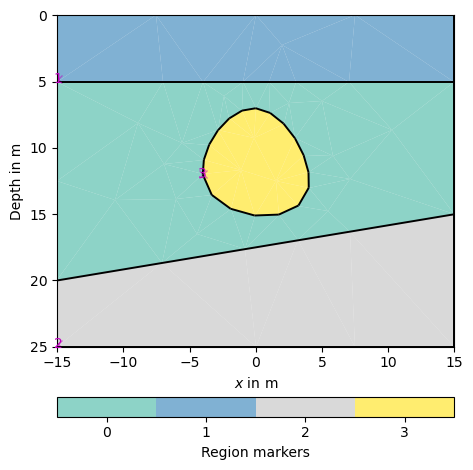

In [56]:
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt

geometry = mt.readPLC("geometry.poly")
geometry.scale([0.5, 1, 1])

ax, _ = pg.show(geometry)

## Define source and receiver positions

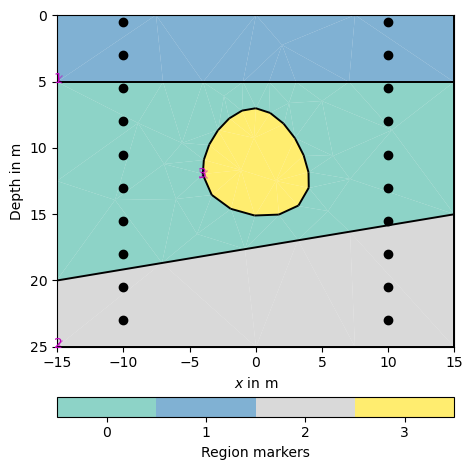

In [57]:
import numpy as np

n = 10 # number of sources and receivers per borehole
borehole = np.ones((n, 2)) * 10 # right borehole at x = 10 m
borehole[:,1] = np.linspace(-.5, -23, n) # down to 23 m depth

sensors = np.vstack([borehole] * 2)
sensors[n:,0] *= -1 # left borehole at x = -10 m

ax.plot(sensors[:,0], sensors[:,1], "ko")
ax.figure

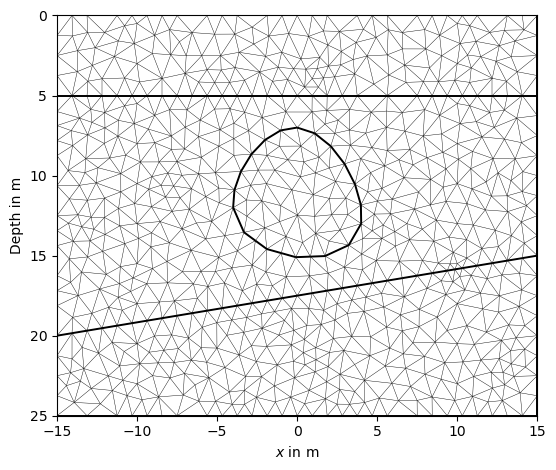

In [58]:
for pos in sensors:
    geometry.createNode(pos)
    
mesh = mt.createMesh(geometry, quality=33.5, area=1)
pg.show(mesh);

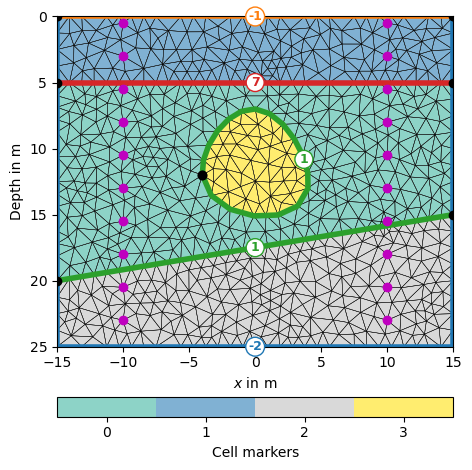

In [59]:
ax, _ = pg.show(mesh, markers=True, showMesh=True)
ax.plot(sensors[:,0], sensors[:,1], "mo");

## Create measurement schedule

In [60]:
scheme = tt.createCrossholeData(sensors)
print(scheme)
print(scheme.sensor(0))
np.column_stack((pg.x(scheme), pg.y(scheme)))

Data: Sensors: 20 data: 100, nonzero entries: ['g', 's', 'valid']
RVector3: (10.0, -0.5, 0.0)


array([[ 10. ,  -0.5],
       [ 10. ,  -3. ],
       [ 10. ,  -5.5],
       [ 10. ,  -8. ],
       [ 10. , -10.5],
       [ 10. , -13. ],
       [ 10. , -15.5],
       [ 10. , -18. ],
       [ 10. , -20.5],
       [ 10. , -23. ],
       [-10. ,  -0.5],
       [-10. ,  -3. ],
       [-10. ,  -5.5],
       [-10. ,  -8. ],
       [-10. , -10.5],
       [-10. , -13. ],
       [-10. , -15.5],
       [-10. , -18. ],
       [-10. , -20.5],
       [-10. , -23. ]])

## Parameterize the subsurface

Now we populate the subsurface with property values on a cell-by-cell basis. We assign values of velocities to all of the cells using `mesh.cellMarkers()`. Note that the markers in this case, start with 0 which works because numpy uses 0 based indexing.

In [61]:
# vmap = [[0, 800], [1, 500], [2, 1000], [3, 2000]] # or populate it directly
v = np.array([800,500,1000,2000])[mesh.cellMarkers()] # Velocities for 4 markers

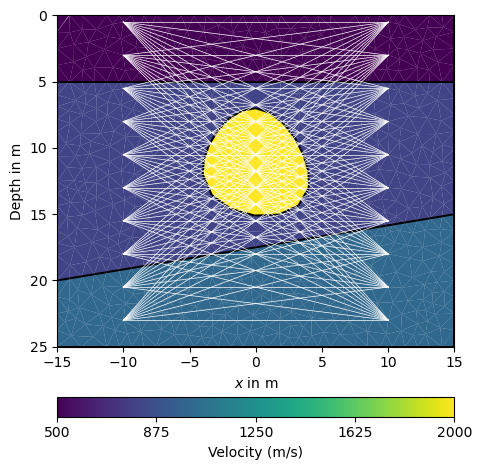

In [62]:
ax, _ = pg.show(mesh, v, label=pg.unit("vel"));

shots = scheme["s"]
geophones = scheme["g"]

for s, g in zip(shots, geophones):
    ray = np.array([s, g])
    ax.plot(sensors[ray, 0], sensors[ray, 1], "w-", lw=0.5)

## Simulate traveltime measurements

The [`TravelTimeManager()`](https://www.pygimli.org/pygimliapi/_generated/pygimli.physics.traveltime.html?highlight=traveltimemanager#pygimli.physics.traveltime.TravelTimeManager) class and method manager for travel time tomography. Below we are using the `mgr.simulate` function. We explain more about the TravelTime Manager in the [next notebook](./4_Traveltime_inversion.ipynb) 

In [63]:
mgr = tt.TravelTimeManager()
data = mgr.simulate(mesh=mesh, scheme=scheme, slowness=1/v,
                   secNodes=4, noiseLevel=0.001, noiseAbs=1e-5, seed=1337)
print(data)
data.save("traveltime.dat")

09/02/25 - 12:08:23 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


Data: Sensors: 20 data: 100, nonzero entries: ['err', 'g', 's', 't', 'valid']


1

In [64]:
np.column_stack((data["s"], data["g"], data["t"]))[:12]

array([[ 0.        , 10.        ,  0.03825934],
       [ 0.        , 11.        ,  0.03408472],
       [ 0.        , 12.        ,  0.03049941],
       [ 0.        , 13.        ,  0.02950028],
       [ 0.        , 14.        ,  0.02915859],
       [ 0.        , 15.        ,  0.02932699],
       [ 0.        , 16.        ,  0.03046252],
       [ 0.        , 17.        ,  0.0320365 ],
       [ 0.        , 18.        ,  0.03336778],
       [ 0.        , 19.        ,  0.03461089],
       [ 1.        , 10.        ,  0.03414275],
       [ 1.        , 11.        ,  0.02988183]])

---
### Appendix
We will have a closer look into the simulated data.

In [65]:
# First retrieve the shot-geophone distances
dist = tt.shotReceiverDistances(data, full=True)
# Next compute apparent velocity by dividing it through the traveltimes
va = dist / data["t"]
# plt.hist(va, bins=30);

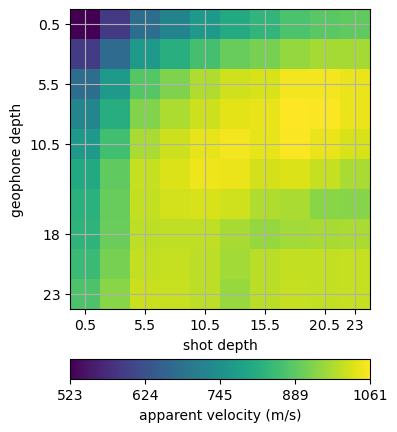

In [66]:
from pygimli.viewer.mpl import showDataContainerAsMatrix, showVecMatrix

d = -pg.y(data)  # sensor depth
ds = d[data["s"]]  # shot depth
dg = d[data["g"]]  # geophone depth
ax, cb = showVecMatrix(ds, dg, va, label="apparent velocity (m/s)");
ax.set_xlabel("shot depth");
ax.set_ylabel("geophone depth");

09/02/25 - 12:08:32 - pyGIMLi - INFO - Creating refined mesh (secnodes: 4) to solve forward task.


Data: Sensors: 20 data: 100, nonzero entries: ['err', 'g', 's', 't', 'valid']


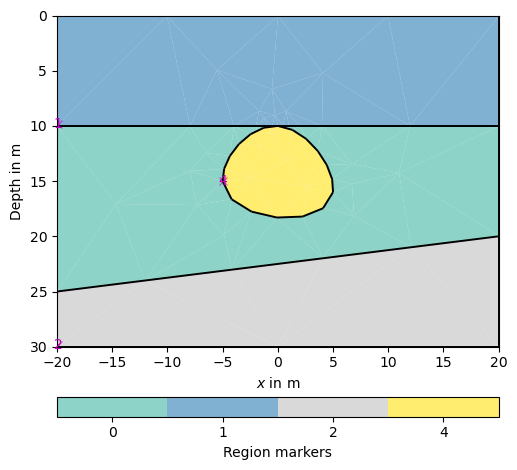

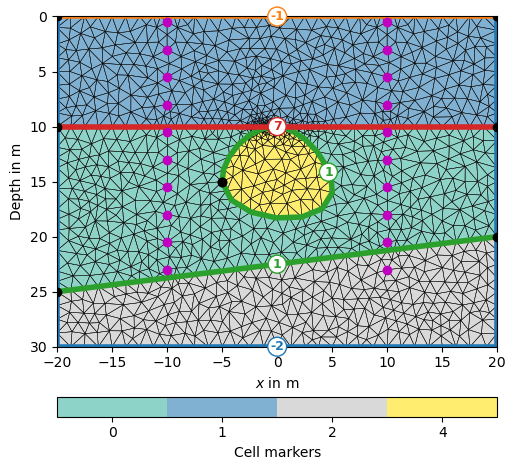

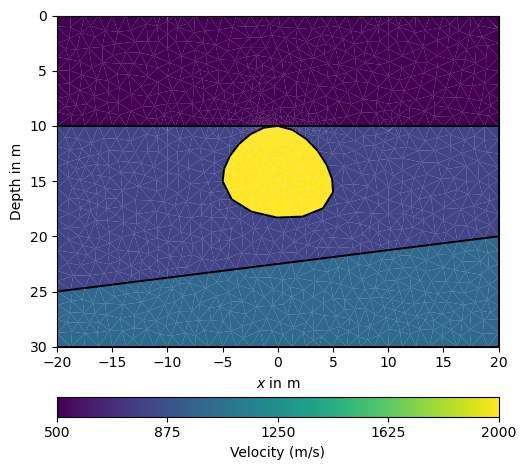

In [67]:
# Read the new geometry and mesh files
new_geometry = mt.readPLC("new_geometry.poly")
new_mesh = mt.createMesh(new_geometry, quality=33.5, area=1)

# Scale the new geometry if needed
new_geometry.scale([0.5, 1, 1])

# Show the new geometry
ax, _ = pg.show(new_geometry)

# Add sensors to the new geometry
for pos in sensors:
    new_geometry.createNode(pos)

# Create a new mesh with the updated geometry
new_mesh = mt.createMesh(new_geometry, quality=33.5, area=1)

# Show the new mesh
ax, _ = pg.show(new_mesh, markers=True, showMesh=True)
ax.plot(sensors[:,0], sensors[:,1], "mo")

# Create a new measurement scheme
new_scheme = tt.createCrossholeData(sensors)

# Define new velocities for the new mesh
new_v = np.array([800, 500, 1000, 2000])[np.clip(new_mesh.cellMarkers(), 0, 3)]

# Show the new mesh with velocities
ax, _ = pg.show(new_mesh, new_v, label=pg.unit("vel"))

# Simulate traveltime measurements with the new mesh and scheme
new_mgr = tt.TravelTimeManager()
new_data = new_mgr.simulate(mesh=new_mesh, scheme=new_scheme, slowness=1/new_v,
                            secNodes=4, noiseLevel=0.001, noiseAbs=1e-5, seed=1337)

# Save the new data
new_data.save("new_traveltime.dat")

# Print the new data
print(new_data)

In [68]:
pg.Report()

--------------------------------------------------------------------------------
  Date: Sun Feb 09 12:08:40 2025 W. Europe Standard Time

                OS : Windows (10 10.0.26100 SP0 Multiprocessor Free)
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 15.7 GiB
       Environment : Jupyter

  Python 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23)
  [MSC v.1942 64 bit (AMD64)]

           pygimli : 1.5.3
            pgcore : 1.5.0
             numpy : 1.26.4
        matplotlib : 3.10.0
             scipy : 1.15.1
              tqdm : 4.67.1
           IPython : 8.32.0
           pyvista : 0.44.2
--------------------------------------------------------------------------------